In [ ]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from matplotlib import cm
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import os
from tqdm import tqdm_notebook  # To know how long the code is processing

from sklearn.model_selection import train_test_split

import keras
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, TimeDistributed
from keras.layers import LeakyReLU, PReLU, ELU, ThresholdedReLU
from keras.metrics import MeanAbsolutePercentageError, MeanSquaredError,RootMeanSquaredError,MeanAbsoluteError
# "mean_absolute_percentage_error" "mean_squared_error" "root_mean_squared_error"  "mean_absolute_error"
from keras import applications
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

Using TensorFlow backend.
C:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [ ]:
with pd.HDFStore('/Users/acer/Documents/31661_41758_compressed_madrid.h5/madrid.h5') as data:
    df = data['28079016']
    
df = df.sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151776 entries, 2001-01-01 01:00:00 to 2018-05-01 00:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   CO      151182 non-null  float64
 1   NO      64045 non-null   float64
 2   NO_2    151290 non-null  float64
 3   NOx     92321 non-null   float64
 4   O_3     151131 non-null  float64
 5   PM10    75920 non-null   float64
 6   SO_2    78497 non-null   float64
dtypes: float64(7)
memory usage: 9.3 MB


In [ ]:
# read train.csv from google drive
path = "/content/gdrive/My Drive/Colab Notebooks/csvs_per_year/madrid.h5"
df = pd.read_hdf(path, '28079016')

df = df.sort_index()
df.info()

FileNotFoundError: File /content/gdrive/My Drive/Colab Notebooks/csvs_per_year/madrid.h5 does not exist

In [ ]:
df.head()

,CO,NO,NO_2,NOx,O_3,PM10,SO_2
date,,,,,,,
2001-01-01 01:00:00,0.59,NaN,46.560001,57.119999,8.61,NaN,13.65
2001-01-01 02:00:00,1.09,NaN,52.369999,98.309998,5.64,NaN,14.94
2001-01-01 03:00:00,1.37,NaN,53.910000,134.100006,5.45,NaN,16.02
2001-01-01 04:00:00,1.45,NaN,53.320000,137.699997,5.46,NaN,16.91
2001-01-01 05:00:00,0.94,NaN,53.860001,100.599998,7.04,NaN,14.52


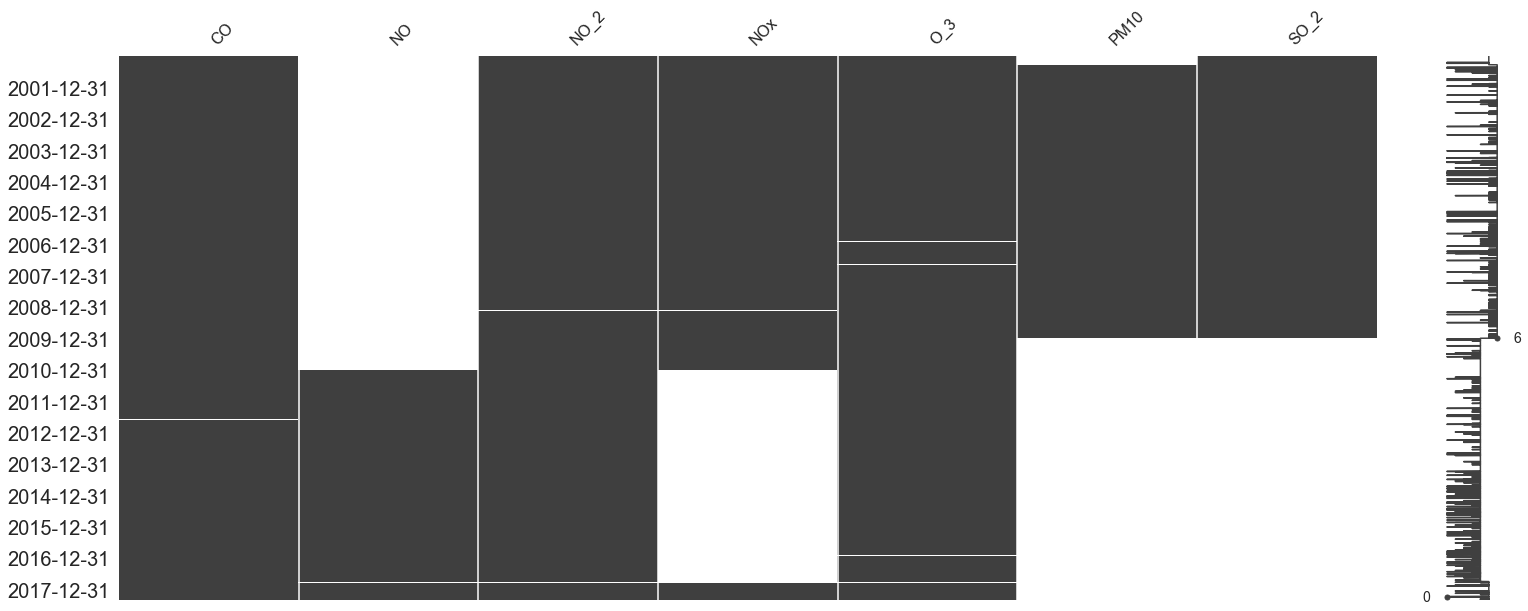

In [ ]:
msno.matrix(df, freq='Y')

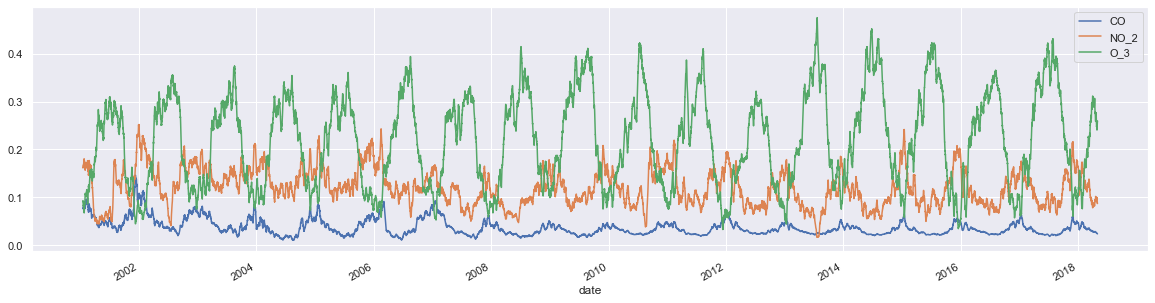

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

candidates = df[['CO', 'NO_2', 'O_3']] 

candidates /= candidates.max(axis=0)

(candidates.interpolate(method='time')
           .rolling(window=24*15).mean()
           .plot(ax=ax))

In [ ]:
def pivot_with_offset(series, offset):
    pivot = pd.DataFrame(index=df.index)

    for t in range(offset * 2):
        pivot['t_{}'.format(t)] = series.shift(-t)

    pivot = pivot.dropna(how='any')
    return pivot


offset = 24

series = (df.NO_2.interpolate(method='time')
                 .pipe(pivot_with_offset, offset)
                 .apply(np.log, axis=1)
                 .replace(-np.inf))

# Get only timestamps at 00:00 and 12:00
series = series[(series.index.hour % 12) == 0]

# Make it a multiple of the chosen batch_size
if series.shape[0] % 32 != 0:
    series = series.iloc[:-(series.shape[0]%32)]

In [ ]:
# split train and validated and test data
valid_ratio = 0.4
test_ratio = 0.2

split_valid = int(series.shape[0] * (1 - valid_ratio))
split_valid -= split_valid % 32

split_test = int(series.shape[0] * (1 - test_ratio))
split_test -= split_test % 32

In [ ]:
np_series = series.values

Xtrain = series.values[:split_valid , :offset]
ytrain = series.values[:split_valid, offset:]
Xvalid = series.values[split_valid:split_test , :offset]
yvalid = series.values[split_valid:split_test, offset:]
Xtest = series.values[split_test:, :offset]
ytest = series.values[split_test:, offset:]

In [ ]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xvalid.shape)
print(yvalid.shape)
print(Xtest.shape)

(7584, 24)
(7584, 24)
(2528, 24)
(2528, 24)
(2528, 24)


In [ ]:
# Scale only to train data to prevent look-ahead bias
lift = Xtrain.min()
scale = Xtrain.max()

def scale_array(arr, lift, scale):
    return (arr - lift) / scale

X_train = np.expand_dims(scale_array(Xtrain, lift, scale), axis=2)
y_train = np.expand_dims(scale_array(ytrain, lift, scale), axis=2)
X_valid = np.expand_dims(scale_array(Xvalid, lift, scale), axis=2)
y_valid = np.expand_dims(scale_array(yvalid, lift, scale), axis=2)
X_test = np.expand_dims(scale_array(Xtest, lift, scale), axis=2)
y_test = np.expand_dims(scale_array(ytest, lift, scale), axis=2)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(7584, 24, 1)
(7584, 24, 1)
(2528, 24, 1)
(2528, 24, 1)
(2528, 24, 1)
(2528, 24, 1)


In [ ]:
def create_lstm_without_batchnormal(offset, neurons=(64,16), batch_size=32, lr=0.005, n_features=1):
    model = Sequential()
    # First LSTM layer
    model.add(LSTM(
        neurons[0], 
        return_sequences=True, stateful=True, 
        batch_input_shape=(batch_size, offset, n_features))
    )
    model.add(Dropout(1))
    # Second LSTM layer if defined
    if neurons[1]:
        model.add(LSTM(
            neurons[1],
            return_sequences=True, stateful=True, 
            batch_input_shape=(batch_size, offset, n_features))
        )
        model.add(Dropout(1))
    # TimeDistributed layer to generate all the timesteps
    model.add(TimeDistributed(Dense(1)))
    optimizer = RMSprop(lr=lr)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


In [ ]:
from keras.layers import BatchNormalization

def create_lstm_BatchNormalization(offset, neurons=(64,16), batch_size=32, lr=0.005, n_features=1):
    model = Sequential()
    # First LSTM layer
    model.add(LSTM(
        neurons[0], 
        return_sequences=True, stateful=True, 
        batch_input_shape=(batch_size, offset, n_features))
    )
    model.add(BatchNormalization())
    # Second LSTM layer if defined
    if neurons[1]:
        model.add(LSTM(
            neurons[1],
            return_sequences=True, stateful=True, 
            batch_input_shape=(batch_size, offset, n_features))
        )
        model.add(BatchNormalization())
    # TimeDistributed layer to generate all the timesteps
    model.add(TimeDistributed(Dense(1)))
    optimizer = RMSprop(lr=lr)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [ ]:
def train_model_with_batchnormalization(model, X_train, y_train, neurons = (32,8),batch_size=32, epochs=20):
    loss_list = list()
    val_loss_list = list()
    for i in range(epochs):
        if i % 1 == 0:
            print('Epoch {:02d}/{}...'.format(i + 1, epochs), end=' ')

        log = model.fit(
            X_train, y_train, 
            validation_data=(X_valid,y_valid),
            epochs=1, batch_size=32, 
            verbose=0, shuffle=False
        )
        val_loss_list.append(log.history['val_loss'][-1])
        loss_list.append(log.history['loss'][-1])
        print('loss: {:.4f}'.format(loss_list[-1]), 'val_loss: {:.4f}'.format(val_loss_list[-1]))
        model.reset_states()
    
    # plot the loss vs. val_loss
    plt.figure(figsize=(10,6))
    plt.plot(loss_list, label='Train')
    plt.plot(val_loss_list, label='Validation')
    plt.title('LSTM - Train & Validation Loss with batch normalization')
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = np.array(val_loss_list)
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))
    return model, loss_list


In [ ]:
def train_model_without_batchnormalization(model, X_train, y_train, neurons = (32,8),batch_size=32, epochs=20):
    loss_list = list()
    val_loss_list = list()
    for i in range(epochs):
        if i % 1 == 0:
            print('Epoch {:02d}/{}...'.format(i + 1, epochs), end=' ')

        log = model.fit(
            X_train, y_train, 
            validation_data=(X_valid,y_valid),
            epochs=1, batch_size=32, 
            verbose=0, shuffle=False
        )
        val_loss_list.append(log.history['val_loss'][-1])
        loss_list.append(log.history['loss'][-1])
        print('loss: {:.4f}'.format(loss_list[-1]), 'val_loss: {:.4f}'.format(val_loss_list[-1]))
        model.reset_states()
    
    # plot the loss vs. val_loss
    plt.figure(figsize=(10,6))
    plt.plot(loss_list, label='Train')
    plt.plot(val_loss_list, label='Validation')
    plt.title('LSTM - Train & Validation Loss withdropout 1')
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = np.array(val_loss_list)
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))
    return model, loss_list


In [ ]:
def validate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    model.reset_states()
    return np.mean((y_test - preds) ** 2)

In [ ]:
# examining and plot the loss value between train data and validation data
'''
def plot_loss(history, activation):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('LSTM - Train & Validation Loss with {}'.format(activation))
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))
'''

"\ndef plot_loss(history, activation):\n    plt.figure(figsize=(10,6))\n    plt.plot(history.history['loss'], label='Train')\n    plt.plot(history.history['val_loss'], label='Validation')\n    plt.title('LSTM - Train & Validation Loss with {}'.format(activation))\n    plt.xlabel('Nb Epochs')\n    plt.ylabel('Loss')\n    plt.legend()\n    plt.show()\n    \n    val_loss = history.history['val_loss']\n    min_idx = np.argmin(val_loss)\n    min_val_loss = val_loss[min_idx]\n    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))\n"

In [ ]:
def plot_pred(X_test, preds, batchnormalization):
  ig, ax = plt.subplots(figsize=(20, 5))

  start = X_test.shape[0] - 42
  interval = X_test[start+3:start+33:2, :, 0].reshape(-1, 1)

  truth, = plt.plot(np.arange(24*15), interval, alpha=0.6)

  old_preds = list()

  for point in range(1, 15, 2):
      prediction = np.squeeze(preds[start + point*2])
      pred, = plt.plot(point * offset + np.arange(offset) - 12, prediction,
                      linestyle='--', color='red')
      old_preds.append(prediction)
  plt.title("Prediction {}".format(batchnormalization) )
  plt.legend(
      [truth, pred],
      ['Observation', 'Prediction']
  )
  ax.set_ylim([-.1, 1.1])
  ax.set_xticks(12 + np.arange(15) * offset)
  _ = ax.set_xticklabels([])


RUNNING without batchnormalization
Epoch 01/20... WARNING:tensorflow:From C:\Users\acer\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

loss: 0.0308 val_loss: 0.0165
Epoch 02/20... loss: 0.0157 val_loss: 0.0156
Epoch 03/20... loss: 0.0126 val_loss: 0.0152
Epoch 04/20... loss: 0.0114 val_loss: 0.0148
Epoch 05/20... loss: 0.0109 val_loss: 0.0146
Epoch 06/20... loss: 0.0107 val_loss: 0.0148
Epoch 07/20... loss: 0.0106 val_loss: 0.0150
Epoch 08/20... loss: 0.0105 val_loss: 0.0157
Epoch 09/20... loss: 0.0105 val_loss: 0.0158
Epoch 10/20... loss: 0.0103 val_loss: 0.0141
Epoch 11/20... loss: 0.0102 val_loss: 0.0162
Epoch 12/20... loss: 0.0101 val_loss: 0.0162
Epoch 13/20... loss: 0.0101 val_loss: 0.0141
Epoch 14/20... loss: 0.0101 val_loss: 0.0142
Epoch 15/20... loss: 0.0099 val_loss: 0.0138
Epoch 16/20... loss: 0.0100 val_loss: 0.0145
Epoch 17/20... loss: 0.0101 val_loss: 0.014

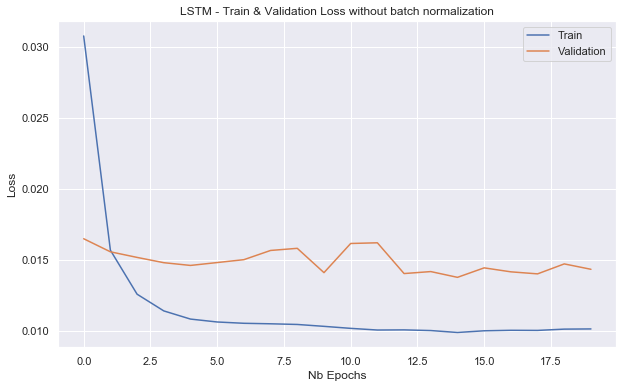

Minimum validation loss of 0.013797258645814808 reached at epoch 14
Epoch 1/1
7584/7584 [==============================] - 5s 615us/step - loss: 0.0101
RUNNING with batchnormalization
Epoch 01/20... loss: 0.1142 val_loss: 0.0331
Epoch 02/20... loss: 0.0143 val_loss: 0.3309
Epoch 03/20... loss: 0.0168 val_loss: 0.3077
Epoch 04/20... loss: 0.0123 val_loss: 0.0498
Epoch 05/20... loss: 0.0117 val_loss: 6.8849
Epoch 06/20... loss: 0.0118 val_loss: 10.3215
Epoch 07/20... loss: 0.0116 val_loss: 21.1780
Epoch 08/20... loss: 0.0116 val_loss: 1.6976
Epoch 09/20... loss: 0.0123 val_loss: 0.9707
Epoch 10/20... loss: 0.0118 val_loss: 0.4843
Epoch 11/20... loss: 0.0116 val_loss: 0.0767
Epoch 12/20... loss: 0.0116 val_loss: 0.0264
Epoch 13/20... loss: 0.0115 val_loss: 0.4163
Epoch 14/20... loss: 0.0115 val_loss: 0.2437
Epoch 15/20... loss: 0.0115 val_loss: 0.0419
Epoch 16/20... loss: 0.0115 val_loss: 0.0197
Epoch 17/20... loss: 0.0115 val_loss: 0.0142
Epoch 18/20... loss: 0.0115 val_loss: 0.0522
Epoc

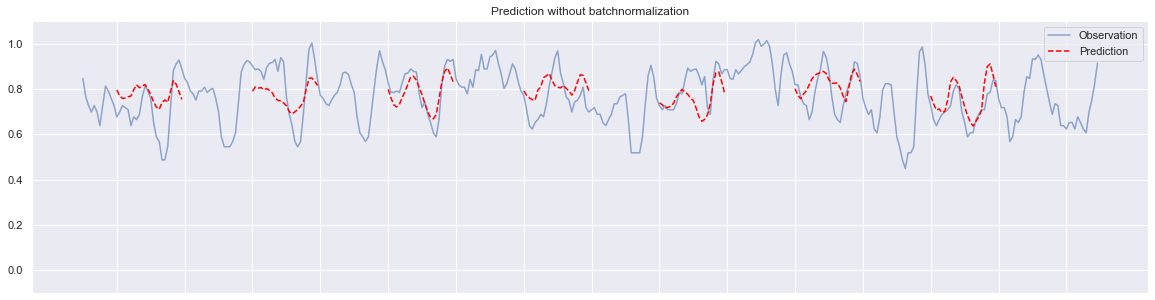

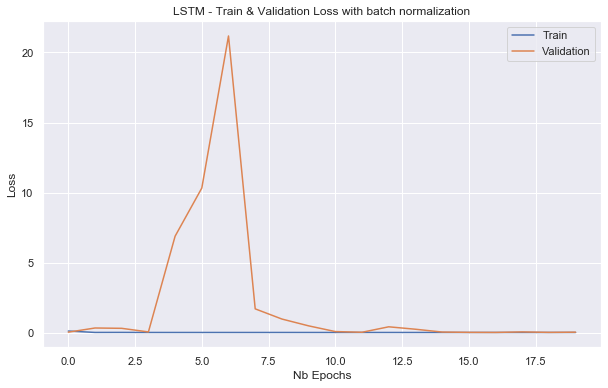

Minimum validation loss of 0.014231514533439392 reached at epoch 16
Epoch 1/1
7584/7584 [==============================] - 5s 646us/step - loss: 0.0117 0s - 


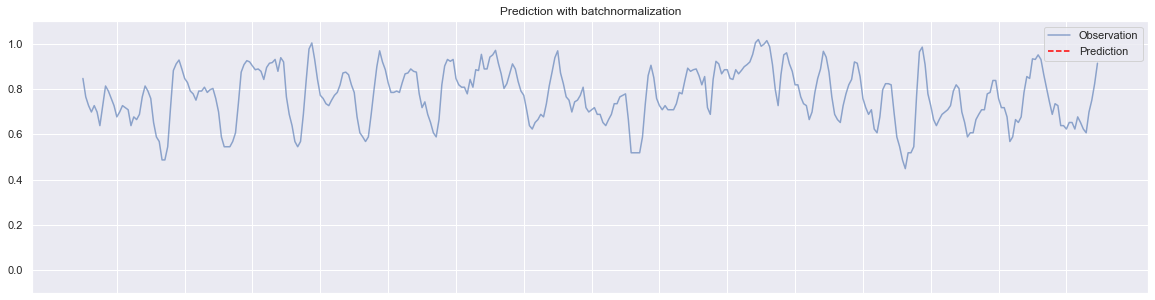

In [ ]:
# Q11 batchnormalization
batchnormalization = "without batchnormalization"

print("RUNNING without batchnormalization")  # stated which neurons is used
model = create_lstm_without_batchnormal(offset)
# model.summary()
model, _ = train_model_without_batchnormalization(model, X_train, y_train)
model.fit(X_train, y_train, batch_size=32, epochs=1, verbose=1, shuffle=False)  # train whole data
preds = model.predict(X_test)  # predict
'MSE: {:.5f}'.format(validate_model(model, X_test, y_test))
model.reset_states()
plot_pred(X_test, preds,batchnormalization)  # print prediction results

# Q11 batchnormalization
batchnormalization = "with batchnormalization"
print("RUNNING with batchnormalization")  # stated which neurons is used
model = create_lstm_BatchNormalization(offset)
 # model.summary()
model, _ = train_model_with_batchnormalization(model, X_train, y_train)
model.fit(X_train, y_train, batch_size=32, epochs=1, verbose=1, shuffle=False)  # train whole data
preds = model.predict(X_test)  # predict
'MSE: {:.5f}'.format(validate_model(model, X_test, y_test))
model.reset_states()
plot_pred(X_test, preds,batchnormalization)  # print prediction results

RUNNING with batchnormalization
Epoch 01/20... loss: 0.0912 val_loss: 0.0552
Epoch 02/20... loss: 0.0153 val_loss: 0.0734
Epoch 03/20... loss: 0.0146 val_loss: 0.0240
Epoch 04/20... loss: 0.0143 val_loss: 0.2522
Epoch 05/20... loss: 0.0133 val_loss: 0.0228
Epoch 06/20... loss: 0.0117 val_loss: 0.9979
Epoch 07/20... loss: 0.0116 val_loss: 0.4404
Epoch 08/20... loss: 0.0117 val_loss: 36.6279
Epoch 09/20... loss: 0.0116 val_loss: 1.4763
Epoch 10/20... loss: 0.0117 val_loss: 7.3904
Epoch 11/20... loss: 0.0116 val_loss: 0.0182
Epoch 12/20... loss: 0.0116 val_loss: 0.3129
Epoch 13/20... loss: 0.0116 val_loss: 1.3113
Epoch 14/20... loss: 0.0116 val_loss: 2.1167
Epoch 15/20... loss: 0.0116 val_loss: 2.5244
Epoch 16/20... loss: 0.0116 val_loss: 0.2120
Epoch 17/20... loss: 0.0116 val_loss: 1.1954
Epoch 18/20... loss: 0.0115 val_loss: 45.9578
Epoch 19/20... loss: 0.0116 val_loss: 0.0151
Epoch 20/20... loss: 0.0116 val_loss: 0.5335


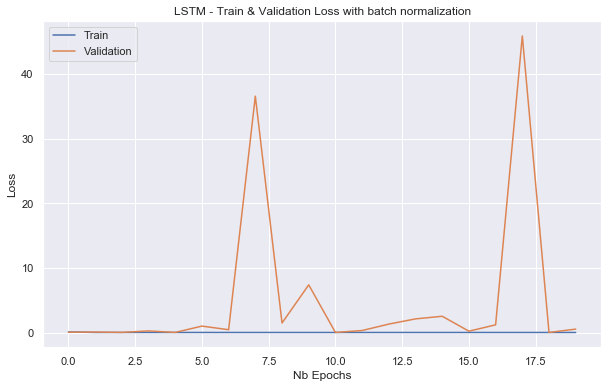

Minimum validation loss of 0.015137522552115253 reached at epoch 18
Epoch 1/1
7584/7584 [==============================] - 5s 618us/step - loss: 0.0116


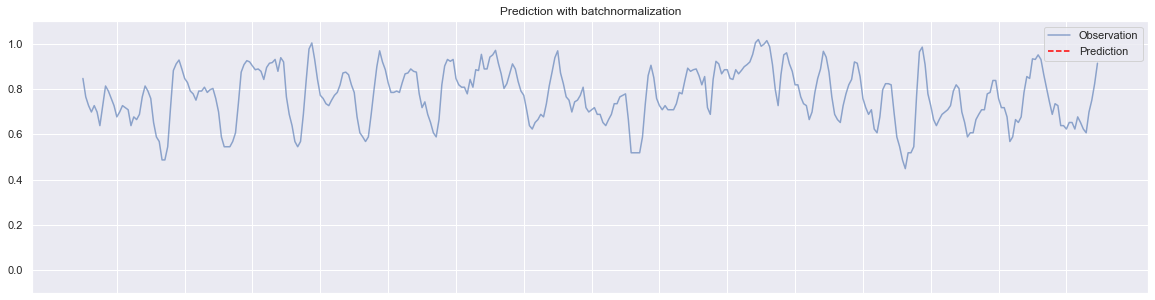

In [ ]:
# Q11 batchnormalization
batchnormalization = "with batchnormalization"
print("RUNNING with batchnormalization")  # stated which neurons is used
model = create_lstm_BatchNormalization(offset)
 # model.summary()
model, _ = train_model_with_batchnormalization(model, X_train, y_train)
model.fit(X_train, y_train, batch_size=32, epochs=1, verbose=1, shuffle=False)  # train whole data
preds = model.predict(X_test)  # predict
'MSE: {:.5f}'.format(validate_model(model, X_test, y_test))
model.reset_states()
plot_pred(X_test, preds,batchnormalization)  # print prediction results

RUNNING without batchnormalization
Epoch 01/20... loss: 0.0214 val_loss: 0.0178
Epoch 02/20... loss: 0.0120 val_loss: 0.0170
Epoch 03/20... loss: 0.0112 val_loss: 0.0148
Epoch 04/20... loss: 0.0108 val_loss: 0.0149
Epoch 05/20... loss: 0.0106 val_loss: 0.0150
Epoch 06/20... loss: 0.0104 val_loss: 0.0152
Epoch 07/20... loss: 0.0103 val_loss: 0.0163
Epoch 08/20... loss: 0.0103 val_loss: 0.0160
Epoch 09/20... loss: 0.0103 val_loss: 0.0150
Epoch 10/20... loss: 0.0102 val_loss: 0.0159
Epoch 11/20... loss: 0.0101 val_loss: 0.0157
Epoch 12/20... loss: 0.0100 val_loss: 0.0141
Epoch 13/20... loss: 0.0100 val_loss: 0.0154
Epoch 14/20... loss: 0.0099 val_loss: 0.0157
Epoch 15/20... loss: 0.0099 val_loss: 0.0156
Epoch 16/20... loss: 0.0099 val_loss: 0.0157
Epoch 17/20... loss: 0.0099 val_loss: 0.0158
Epoch 18/20... loss: 0.0099 val_loss: 0.0150
Epoch 19/20... loss: 0.0098 val_loss: 0.0151
Epoch 20/20... loss: 0.0098 val_loss: 0.0139


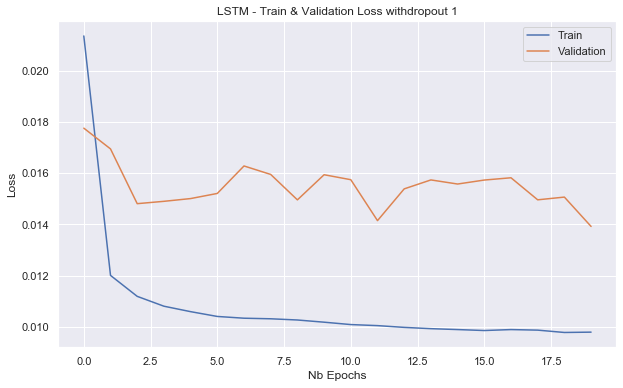

Minimum validation loss of 0.013921617371136253 reached at epoch 19
Epoch 1/1
7584/7584 [==============================] - 4s 569us/step - loss: 0.0098


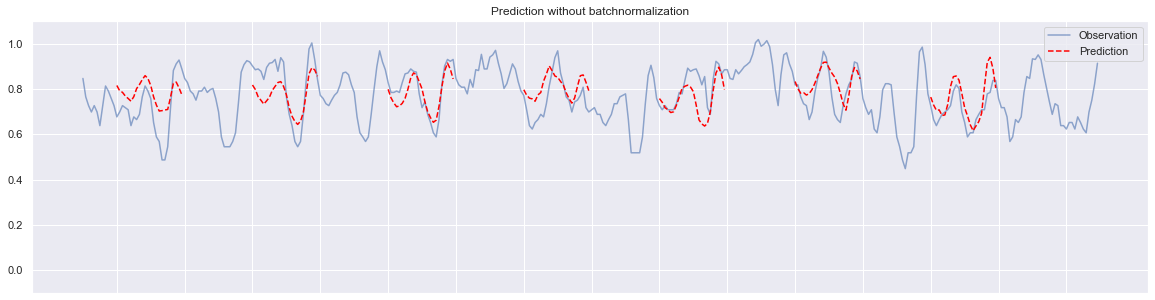

In [ ]:
# Q11 batchnormalization
batchnormalization = "without batchnormalization"

print("RUNNING without batchnormalization")  # stated which neurons is used
model = create_lstm_without_batchnormal(offset)
# model.summary()
model, _ = train_model_without_batchnormalization(model, X_train, y_train)
model.fit(X_train, y_train, batch_size=32, epochs=1, verbose=1, shuffle=False)  # train whole data
preds = model.predict(X_test)  # predict
'MSE: {:.5f}'.format(validate_model(model, X_test, y_test))
model.reset_states()
plot_pred(X_test, preds,batchnormalization)  # print prediction results